# Sentiment Analysis P1

In this notebook, you will learn how to use different packages in Python to build a complete pipeline for solving sentiment analysis problem. We will be using the simplest model, Mutinomial NB, in this class.

## Pipeline

<img src="resources/pipeline.png">

## Get familiar with dataset

In [7]:
#!pip install wget

In [8]:
import pandas as pd
from utils import get_imdb_dataset#help to download IMDB dataset automatically

pd.set_option('max_colwidth', 500)  # Set display column width to show more content

In [9]:
# Load dataset, download if necessary
train, test = get_imdb_dataset()

data already available, skip downloading.
imdb loaded successfully.


In [10]:
# Get a sample (head) of the data frame
train.sample(5)

,text,sentiment
23230,"<br /><br />How this film ever got a 6 star average is beyond me. The script is so banal, and frankly an insult to whomevers life it is based upon. The cinematography comes straight from the slick world of advertising, and the talented Ridley Scott should be ashamed. Demi Moore however, shows none a surprise by participating in this film, if one looks at her tracklist. All in all, a ""high concept"" style film that even Don Simpson would be ashamed of.",neg
20156,"If you haven't figured out what is going to happen in this film in the first five minutes then give it a couple more minutes. Lilia is a widow. She has been left on the shelf for too long and she wants to burst out. She has a teenage daughter which only highlights that she is not getting any younger. While checking up on her daughter she discovers a world she never dared...the cabaret, where she can belly dance in skimpy sequined outfits while men throw money at her. The film is very misogam...",neg
17208,"An actor's first film is usually something one can afford to miss - it's often that first job where the lack of film experience by everyone involved is truly on display, and this film is no exception.<br /><br />But worse than that, even by 1982 standards this is so bad, it's hysterically funny. Filmed entirely in the Chicago area on an obviously small budget, most of the acting by the entire cast is stiff, wooden, and cartoonish - a cross between a high school play and bad community theater...",neg
19229,"Quite possibly the nicest woman in show business, and the sexiest, Debbie gives another fine performance here. Although her work in American Nightmare was far superior, she is still worth watching in this film.<br /><br />The cast is filled with your typical Melrose Place types, chiseled features and seductive curves, that I had never seen before. Other than Debbie, Laura Nativo was the only actress I had seen before, in the similar Delta Delta Die.<br /><br />The plot centers around a group...",neg
808,"Netflix should mention this short feature on the info for Silk Stockings. Superior in every way to that over-produced fluff. This had much better Cole Porter songs and lots more energy. Silk Stockings turned out to be a big disappointment. Fred was getting too old for this sort of thing, though the dances and Cyd are lovely. I will be on the watch for the Garbo--Melvyn Douglas version of Ninotchka. Was Peter Lorre ill during the making of Silk Stockings--he seems to be very passive in the mo...",pos


In [12]:
print('train shape:', train.shape)
print('test  shape:', test.shape)

train shape: (25000, 2)
test  shape: (25000, 2)


In [13]:
# Statics on tags
train['sentiment'].value_counts()

neg    12500
pos    12500
Name: sentiment, dtype: int64

See [Pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/10min.html?highlight=data%20frame) for more details.

## Preprocessing

### Tokenization and Normalization

For preprocessing, we will apply the following steps:

1. Remove HTML tag (`<br />` in this case) from the review text
2. Remove punctuations (replace with whitespace)
3. Split review text into tokens
4. Remove tokens that are considered as "**stopwords**"
    stopwords: high frequency, low suggestion meaning 
5. For the rest, do lemmatization

In [14]:
import nltk
import string

In [15]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
transtbl = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
#用空白替换标点符号
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer() #把不同形态的单词变回原型

In [17]:
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [18]:
'ababc'.translate(str.maketrans('abc','def'))
#是一一对应关系

'dedef'

In [19]:
def preprocessing(line: str) -> str:
    """
    Take a text input and return the preprocessed string.
    i.e.: preprocessed tokens concatenated by whitespace
    """
    line = line.replace('<br />', '').translate(transtbl)
    
    # list
    tokens = [lemmatizer.lemmatize(t.lower(),'v')
              for t in nltk.word_tokenize(line) 
              if t.lower() not in stopwords] #将变回原形的且不属于stopwords的单词变成小写,stopwords就会被删除
    #返还空格键+处理后的词
    return ' '.join(tokens)

In [20]:
test_str = "I bought SEVERAL books yesterday<br /> and I really love them!"
preprocessing(test_str)
#是否考虑加入感叹号的情感因素

'buy several book yesterday really love'

In [21]:
#nltk.download()

In [22]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

In [23]:
# If you're using macOS and Linux, you may run un-comment the following code to speed up the preprocessing

#!pip install pandarallel
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

  Stored in directory: /Users/AliceLan/Library/Caches/pip/wheels/fa/70/d9/6a27d7fdddb6a7c10af68fffaf6f0a96846c750a840280f7bc
Successfully built pandarallel
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [ ]:
# If you're using Windows, run the following, otherwise, comment this out, and run the second statement instead
#for df in train, test:
#    df['text_prep'] = df['text'].progress_apply(preprocessing)
    
# If you're using macOS or Linux, un-comment and run the following code
for df in train, test:
    df['text_prep'] = df['text'].parallel_apply(preprocessing)

In [27]:
assert train.shape == (25000, 3)
assert test.shape == (25000, 3)
#telling the program to test that condition, and immediately trigger an error if the condition is false.

AssertionError: 

In [ ]:
train.sample(2)
#how to deal with 2 and 3?

### Build Vocabulary

Instead of using `CountVectorizer` (N-gram) provided by sklearn directly, we will build the vocabulary on our own, so that we have more control over it.

<span style="color:red">**Tips:**</span>

We can only use words in training data for building vocabulary

In [ ]:
all_words = [w for text in tqdm_notebook(train['text_prep']) 
             for w in text.split()]
#for each text_prep, split all words

In [ ]:
# Use FreqDist to get count for each word
voca = nltk.FreqDist(all_words)
print(voca)

In [ ]:
voca.most_common(10)

In [ ]:
topwords = [word for word, _ in voca.most_common(10000)]
topwords #as vocabullary

### Vectorizer

For this section, we will try two ways to do vectorization: **BoW** (bag of words)(1-gram) and **BoW with Tfidf Transformer**.

词袋模型首先会进行分词，在分词之后，通过统计每个词在文本中出现的次数，我们就可以得到该文本基于词的特征，如果将各个文本样本的这些词与对应的词频放在一起，就是我们常说的向量化。

向量化完毕后一般也会使用 TF-IDF 进行特征的权重修正，再将特征进行标准化. 

再进行一些其他的特征工程后，就可以将数据带入机器学习模型中计算。 

词袋模型的三部曲：分词（tokenizing），统计修订词特征值（counting）与标准化（normalizing）。

词袋模型有很大的局限性，因为它仅仅考虑了词频，没有考虑上下文的关系，因此会丢失一部分文本的语义。

在词袋模型统计词频的时候，可以使用 sklearn 中的 CountVectorizer 来完成。

In [25]:
from sklearn.feature_extraction.text import (
    CountVectorizer, 
    TfidfTransformer, 
    TfidfVectorizer,)

In [25]:
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

### Tf–idf Transformer

- Tf: Term-Frequency
- idf: Inverse Document-Frequency
- Tf-idf = $tf(t,d) \times idf(t)$

$$
idf(t) = log{\frac{1 + n_d}{1 + df(d, t)}} + 1
$$

![](http://www.onemathematicalcat.org/Math/Algebra_II_obj/Graphics/log_base_gt1.gif)

n_d = # of documents

df = # of documents does a term show up to

用于调整词频：结果有意义强烈的词，词频会被放大。

无用多频的词，词频不变。

> Sentence 1: The boy **love** the toy <br>
> Sentence 2: The boy **hate** the toy

In [26]:
transformer = TfidfTransformer(smooth_idf=False)#smooth_idf默认是true
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False, use_idf=True)

In [27]:
counts = [[3, 0, 1],
          [2, 0, 0],
          [3, 0, 0],
          [4, 0, 0],
          [3, 2, 0],
          [3, 0, 2]]
tfidf = transformer.fit_transform(counts)
tfidf

<6x3 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [32]:
tfidf.toarray()

array([[0.81940995, 0.        , 0.57320793],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.47330339, 0.88089948, 0.        ],
       [0.58149261, 0.        , 0.81355169]])

<span style="color:red">**Tips:**</span>

tf-idfs are computed slightly different in sklearn, where:

$$
idf(t) = log{\frac{n_d}{1 + df(d, t)}}
$$

With `smooth_idf=True` set to `True`, the formula is:

$$
idf(t) = log{\frac{n_d}{df(d, t)}} + 1
$$


It's always worth trying tfidf transformer for text classification problem. Since `CountVectorizer` and `TfidTransformer` are often chained together, sklearn also provide a class that combines the two steps together: `TfidfVectorizer`.

In [34]:
TfidfVectorizer()

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

Let's take the sentences from the slide as an example:

In [35]:
t_corpus = ['the boy love the toy', 'the boy hate the toy']

In [36]:
# Bag of words
# Voc = ['boy', 'hate', 'love', 'the', 'toy']

t_cnt_vec = CountVectorizer()
t_cnt_vec.fit(' '.join(t_corpus).split())
t_cnt_vec.transform(t_corpus).toarray()

array([[1, 0, 1, 2, 1],
       [1, 1, 0, 2, 1]])

In [37]:
# Tfidf
#更精准鞋
t_tfidf_vec = TfidfVectorizer()
t_tfidf_vec.fit(' '.join(t_corpus).split())
t_tfidf_vec.transform(t_corpus).toarray()

array([[0.41508858, 0.        , 0.48828702, 0.6457389 , 0.41508858],
       [0.41508858, 0.48828702, 0.        , 0.6457389 , 0.41508858]])

### Vectorization / Featurization

In [38]:
train_x, train_y = train['text_prep'], train['sentiment']
test_x, test_y = test['text_prep'], test['sentiment']

In [40]:
# Use topwords as vocabulary
tf_vec = TfidfVectorizer(vocabulary=topwords)
#“vocabulary=topwords”通过定义词汇表，避免让Tfi自己学习一个没有topwords词频顺序的词汇表

In [41]:
train_features = tf_vec.fit_transform(train_x)
#对训练用的文本用fit_transform, 对test的文本用transform
#fit_transform is the combination of two functionsfit and transform on the same matrix
test_features = tf_vec.transform(test_x)

In [42]:
assert train_features.shape == (25000, 10000)
#长度和单词表长度一样
assert test_features.shape == (25000, 10000)

In [43]:
train_features[0][:50].toarray()

array([[0.        , 0.12884974, 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Training

### [Multinomial NB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

The multinomial Naive Bayes classifier is suitable for **classification with discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [44]:
from sklearn.naive_bayes import MultinomialNB

In [47]:
mnb_model = MultinomialNB()
mnb_model
#understand all features
#alpha=1.0 如果一个单词不在库里出现过，则我们假设它出现过alpha=1.0次
#class_prior=None, fit_prior=True是关联的
#当fit_prior=True，class_prior不被考虑。fit_prior=True意味着自动计算NB中Pr(pos)和Pr(neg)在documents中的比例
#当fit_prior=False，class_prior则会开启手动输入模式，class_prior=0.8意味着pr(pos)=0.8

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [48]:
%%time

# Train Model
#NB计算了一个频率表，没有迭代的过程，所以很快fit 好
mnb_model.fit(train_features, train_y)

CPU times: user 94.3 ms, sys: 4.81 ms, total: 99.1 ms
Wall time: 102 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

可以试试SVM

## Evaluation

In [49]:
from sklearn import metrics

In [50]:
# Predict on test set
pred = mnb_model.predict(test_features)
print(pred)

['neg' 'pos' 'pos' ... 'neg' 'neg' 'neg']


In [51]:
print('Accuracy: %f' % metrics.accuracy_score(pred,test_y))

Accuracy: 0.833120


<span style="color:red">**Tips:**</span>

It doesn't matter if you change the order of `pred` and `test_y` passed into `accuracy_score` since the metrics is symmetric. **However**, it is extremely important that you pass them in the correct order when you need to calculate per-class metrics like f-score.

In [52]:
# Pass in as keyword arguments to make sure the order is correct
print(
    metrics.classification_report(y_true=test_y, y_pred=pred))
#neg recall=0.87, pos precision =0.86, means that the classifer tend to predict the outcome as neg
#weighted average f1 score: the performance of the classifier taking consider of both neg and pos

              precision    recall  f1-score   support

         neg       0.81      0.87      0.84     12500
         pos       0.86      0.80      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



In [53]:
# Example from sklearn documentation

y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2']
print(metrics.classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.50      1.00      0.67         1
     class 1       0.00      0.00      0.00         1
     class 2       1.00      0.67      0.80         3

    accuracy                           0.60         5
   macro avg       0.50      0.56      0.49         5
weighted avg       0.70      0.60      0.61         5



## Predict new text

In [54]:
def predict_new(prep_func,  # func for preprocessing
                vec,        # vectorizer
                model,      # model
                text):      # text
    
    prep_text = prep_func(text)
    features = vec.transform([prep_text])#put prep_text into list, since transform and model expect their intake to be list
    pred = model.predict(features)#output a list
    return pred[0] 

In [55]:
from functools import partial

predict_new_p1 = partial(predict_new, preprocessing, tf_vec, mnb_model)

In [57]:
predict_new_p1('It looks bad')

'neg'

两个遗留问题：\
1.向量化bag of words带来的的稀疏性没有得到解决\
2.10000长度的单词表是不是最好的长度选择？

topwords = [word for word, _ in voca.most_common(n)]

## Tunning hyper parameters

In [59]:
def train_with_n_topwords(n: int, tfidf=False) -> tuple:
    """
    Train and get the accuracy with different model settings
    Args:
        n: number of features (top frequent words in the vocabulary)
        tfidf: whether do tf-idf re-weighting or not
    Outputs:
        tuple: (accuracy score, classifier, vectorizer)
    """
    topwords = [word for word, _ in voca.most_common(n)]
    
    if tfidf:
        vec = TfidfVectorizer(vocabulary=topwords)
    else:
        vec = CountVectorizer(vocabulary=topwords)
    
    # Generate feature vectors
    train_features = vec.fit_transform(train_x)
    test_features  = vec.transform(test_x)
    
    # NB
    mnb_model = MultinomialNB()
    mnb_model.fit(train_features, train_y)
    
    # Test predict
    pred = mnb_model.predict(test_features)
    
    return metrics.accuracy_score(pred, test_y), mnb_model, vec

In [60]:
train_with_n_topwords(500, tfidf=True)

(0.82496,
 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True,
                 vocabulary=['film', 'movie', 'one', 'make', 'like', 'see',
                             'get', 'time', 'good', 'character', 'go', 'watch',
                             'even', 'would', 'think', 'story', 'really', 'well',
                             'show', 'look', 'much', 'say', 'end', 'know',
                             'people', 'bad', 'also', 'first', 'great', 'give', ...]))

In [61]:
possible_n = [500 * i for i in range(1, 20)]

cnt_accuracies = []
tfidf_accuracies = []

for n in tqdm_notebook(possible_n):
    cnt_accuracies.append(train_with_n_topwords(n)[0])
    tfidf_accuracies.append(train_with_n_topwords(n, tfidf=True)[0])

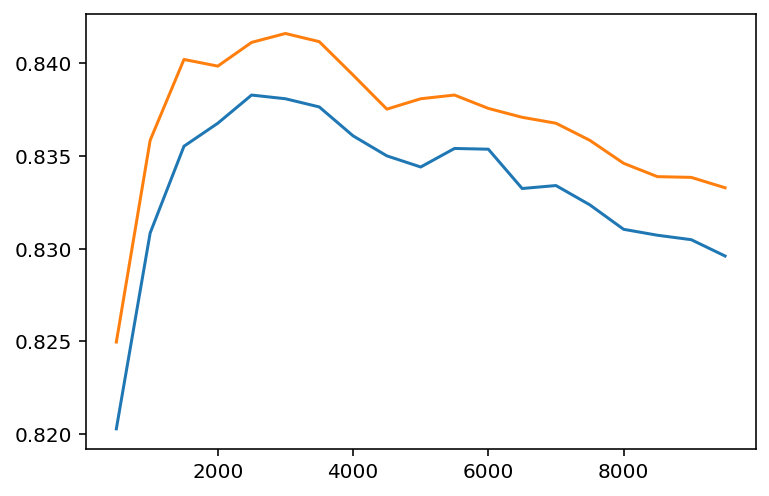

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.plot(possible_n, cnt_accuracies, label='Word Count')
plt.plot(possible_n, tfidf_accuracies, label='Tf-idf')
#单词太少时，向量化会丢失很多信息
#单词太多时，每个单词的重要性都会被稀释掉

**Expected**:

<img src="resources/plot.png" width="400">

## Save model

In [63]:
_, model, vec = train_with_n_topwords(3000, tfidf=True)

In [64]:
import pickle

with open('tf_vec.pkl', 'wb') as fp:
    pickle.dump(vec, fp)
    
with open('mnb_model.pkl', 'wb') as fp:
    pickle.dump(model, fp)
    
with open('preprocessing.pkl', 'wb') as fp:
    pickle.dump(preprocessing, fp)